# Homework #3 - Labeled Faces in the Wild

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from PIL import Image

# On interactive mode for plotting
plt.ion()

In [2]:
# Load dataset
X_train_raw = np.load('X_train.npy')
X_test_raw = np.load('X_test.npy')
y_train_raw = np.load('y_train.npy')

# Calculate mean and standard deviation for normalizaion using training and testing dataset.
full_train = np.concatenate((X_train_raw, X_test_raw), axis=0)
full_mean = np.mean(full_train)/255
full_std = np.std(full_train)/255

In [3]:
# Dataset class to wrap our dataset
class FacesDataset(Dataset):
    """Faces dataset."""

    def __init__(self, X, y, transform=None):
        self.image_vectors = X
        self.targets = y
        self.transform = transform

    def __len__(self):
        return len(self.image_vectors)

    def __getitem__(self, idx):

        one_dim_avg = self.image_vectors[idx]
        one_dim_image = np.reshape(one_dim_avg, (50, 37)).astype('uint8')
        im = Image.fromarray(one_dim_image)
        imrgb = Image.merge('RGB', (im, im, im))

        if self.transform:
            imrgb = self.transform(imrgb)

        return (imrgb, self.targets[idx])


In [4]:
# Data transformations for training and validation dataset
# Training dataset is transformed with random horizontal flips
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[full_mean, full_mean, full_mean],
                             std=[full_std, full_std, full_std])
    ]),
    'val': transforms.Compose([
        transforms.Scale(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[full_mean, full_mean, full_mean],
                             std=[full_std, full_std, full_std])
    ]),
}

In [5]:
# Split to training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_raw,
                                                  y_train_raw,
                                                  random_state=1)

# Wrap training and validation dataset as Datasets
faces_datasets = {
    'train': FacesDataset(X_train, y_train,
                          transform=data_transforms['train']),
    'val': FacesDataset(X_val, y_val, transform=data_transforms['val'])
}

# Create Dataloaders for training and validation dataset
dataloaders = {x: DataLoader(faces_datasets[x], batch_size=4,
                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}

# Size of training and validation dataset
dataset_sizes = {x: len(faces_datasets[x]) for x in ['train', 'val']}

# Checks if GPU is available
use_gpu = torch.cuda.is_available()

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # Starts recording time
    since = time.time()
    
    # Keeps track of best parameters and f1 score from validation phase
    best_model_wts = model.state_dict()
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Train and validate for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            # Keeps track of epoch loss, labels vs predictions
            running_loss = 0.0
            running_labels = torch.LongTensor()
            running_predictions = torch.LongTensor()

            # Iterate data using dataloaders
            for data in dataloaders[phase]:
                inputs, labels = data

                # Wrap inputs and labels in Variables
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward and loss calculation
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # Backward and optimize if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_labels = torch.cat((running_labels, labels.data), 0)
                running_predictions = torch.cat((running_predictions, preds), 0)

            epoch_loss = running_loss / dataset_sizes[phase]
            
            # Calculate f1_score using true labels and predictions
            epoch_f1 = f1_score(running_labels.numpy(), running_predictions.numpy(), average='macro')

            print('{} Loss: {:.4f} F1: {:.4f}'.format(
                    phase, epoch_loss, epoch_f1))
            
            # Update best parameters and f1 score if in validation phase
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = model.state_dict()

        print()
        
    # Compute total time
    time_elasped = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elasped // 60, time_elasped % 60))
    print('Best val F1: {:4f}'.format(best_f1))

    # Return model with optimized parameters
    model.load_state_dict(best_model_wts)
    return model


In [7]:
# Visualize an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([full_mean, full_mean, full_mean])
    std = np.array([full_std, full_std, full_std])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
    # Pause a bit so that plots are updated
    plt.pause(0.001)


In [8]:
# Display predictions for a few images with given model
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(preds[j]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return


Epoch 0/24
----------
train Loss: 0.2806 F1: 0.4756
val Loss: 0.0801 F1: 0.9072

Epoch 1/24
----------
train Loss: 0.0677 F1: 0.8909
val Loss: 0.0239 F1: 0.9564

Epoch 2/24
----------
train Loss: 0.0350 F1: 0.9364
val Loss: 0.0153 F1: 0.9818

Epoch 3/24
----------
train Loss: 0.0189 F1: 0.9801
val Loss: 0.0055 F1: 0.9939

Epoch 4/24
----------
train Loss: 0.0048 F1: 0.9915
val Loss: 0.0072 F1: 0.9899

Epoch 5/24
----------
train Loss: 0.0067 F1: 0.9931
val Loss: 0.0953 F1: 0.9208

Epoch 6/24
----------
train Loss: 0.0066 F1: 0.9956
val Loss: 0.0118 F1: 0.9821

Epoch 7/24
----------
train Loss: 0.0037 F1: 0.9948
val Loss: 0.0103 F1: 0.9862

Epoch 8/24
----------
train Loss: 0.0015 F1: 1.0000
val Loss: 0.0081 F1: 0.9899

Epoch 9/24
----------
train Loss: 0.0019 F1: 0.9987
val Loss: 0.0074 F1: 0.9899

Epoch 10/24
----------
train Loss: 0.0017 F1: 0.9987
val Loss: 0.0091 F1: 0.9899

Epoch 11/24
----------
train Loss: 0.0015 F1: 0.9982
val Loss: 0.0076 F1: 0.9899

Epoch 12/24
----------
tra

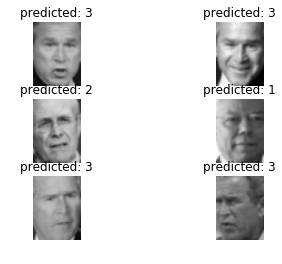

In [9]:
# Transfer learning of resnet34 model is used
model_ft = models.resnet34(pretrained=True)

# Swap out the last layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

# Loss is calculated using cross entropy
criterion = nn.CrossEntropyLoss()

# Parameters are optimized using stochastic gradient descent
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Set step size and decay for learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 25

# Train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs)

# Display predictions for a few images with trained model
visualize_model(model_ft)

# Off interactive mode for plotting
plt.ioff()
plt.show()

In [10]:
# Save model parameters only
torch.save(model_ft.state_dict(), 'resnet34_{}epochs.pt'.format(num_epochs))

# Save entire model
torch.save(model_ft, 'resnet34_{}epochs.model'.format(num_epochs))

In [11]:
# Predict classes of dataset with given model
def predict(X, model):
    dataset = FacesDataset(X, np.zeros(X.shape),
                                transform=data_transforms['val'])

    dataloader = DataLoader(dataset, batch_size=4, num_workers=4)

    results = np.array([])

    for i, data in enumerate(tqdm(dataloader)):
            inputs, _ = data
            if use_gpu:
                inputs = Variable(inputs.cuda())
            else:
                inputs = Variable(inputs)

            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            results = np.append(results, preds.numpy())
            
    return results

In [12]:
# Predict classes of test dataset
predictions = predict(X_test_raw, torch.load('resnet34_25epochs.model'))

# Save predictions of test dataset as csv
with open('output34_25.csv', 'w') as f:
    f.write('ImageId,PredictedClass\n')
    for i in range(len(X_test_raw)):
        f.write('{},{}\n'.format(i, int(predictions[i])))

100%|██████████| 81/81 [01:28<00:00,  1.09s/it]


In [13]:
# Evaluate training performance
train_preds = predict(X_train_raw, torch.load('resnet34_25epochs.model'))
train_f1 = f1_score(y_train_raw, train_preds, average='macro')
print('Training performance')
print('F1: {}'.format(train_f1))

100%|██████████| 242/242 [04:27<00:00,  1.11s/it]

Training performance
F1: 0.9971120591113548
